In [40]:
from tensorly.decomposition import non_negative_tucker
import tensorly as tl
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import pickle
import sys
sys.path.insert(0, '..')
import dataset

In [41]:
patient_col = 'Sample'
image_col = 'Image'
neigh_col = 'CN'
ct_col = 'CT'

In [42]:
ds = pickle.load(open('../data/CRC/CRC_ds.pkl', 'rb'))
df = pd.read_csv('../data/CRC/CRC_df.csv')
cells = ds.ct_order
df_cells = np.zeros((len(df), len(cells)), dtype='int')
df_cells[[i for i in range(len(df))], [cells.index(i) for i in df[ct_col]]] = 1
df[cells] = df_cells

# Uncomment one of these results on CRC

# nbs = [0, 1, 2, 3, 4, 5, 6, 7, 8]
# cns = pickle.load(open('../cn/CRC/CF-IDF/cns_n_cns=9_eps=32.0_r=0.8_max_neighbors=-1_exclude_cts=[]_seed=0_Naive_3.pkl', 'rb'))
# ind = ['CN-1: Macrophage enriched', 'CN-2: Macrophage & mixed cell enriched', 'CN-3: Smooth muscle', 'CN-4: Granulocyte enriched', 'CN-5: T cell enriched', 'CN-6: Undefined cell enriched', 'CN-7: Immune cell / vasculature enriched', 'CN-8: Immune-infiltrated stroma', 'CN-9: Bulk tumor']

nbs = [0, 1, 2, 4, 5, 6, 7, 8]
cns = pickle.load(open('../cn/CRC/CNE/cns_n_cns=9_eta=2.0_max_neighbors=-1_exclude_cts=[]_seed=0_Naive_3.pkl', 'rb'))
ind = ['CN-1: Smooth muscle', 'CN-2: Immune-infiltrated stroma', 'CN-3: Bulk tumor', 'CN-4: Follicle', 'CN-5: Granulocyte enriched', 'CN-6: Immune cell enriched', 'CN-7: T cell enriched', 'CN-8: Tumor boundary', 'CN-9: Macrophage enriched']

# nbs = [0, 1, 3, 4, 5, 6, 7, 8]
# cns = pickle.load(open('../cn/CRC/Spatial LDA/cns_n_cns=9_eps=50.0_b=0.025_train_size_fraction=0.99_n_processes=8_Naive_3.pkl', 'rb'))
# ind = ['CN-1: Granulocyte enriched', 'CN-2: Immune-infiltrated stroma & tumor boundary', 'CN-3: Follicle', 'CN-4: T cell enriched', 'CN-5: Smooth muscle', 'CN-6: Vasculature, macrophage & plasma enriched', 'CN-7: Undefined cell enriched', 'CN-8: Macrophage & T cell enriched', 'CN-9: Bulk tumor']

In [43]:
cells_of_interest = ['Granulocytes',
 'Vasculature',
 'CD4+ T cells CD45RO+',
 'Tumor cells',
 'Stroma',
 'CD68+CD163+ macrophages',
 'Adipocytes',
 'Plasma cells',
 'CD8+ T cells',
 'Tregs',
 'CD4+ T cells',
 'CD11c+ DCs',
 'B cells',
 'CD11b+CD68+ macrophages',
 'Smooth muscle',
 'Tumor cells / immune cells',
 'Immune cells / vasculature',
 'Immune cells',
 'NK cells',
 'Nerves',
 'CD68+ macrophages GzmB+',
 'CD68+ macrophages',
 'Lymphatics',
 'CD11b+ monocytes']

In [44]:
df[neigh_col] = 0
for sample, df_sample in df.groupby(patient_col, sort=False):
    for image, df_image in df_sample.groupby(image_col, sort=False):
        df.loc[df_image.index, neigh_col] = cns[sample][image]
df = pd.DataFrame(df, columns=cells + [ct_col, neigh_col, patient_col])

In [45]:
patients_CLR = ds.group2sample['CLR']
patients_DII = ds.group2sample['DII']

In [46]:
def build_tensor(patients,x,nbs,cells_of_interest):
    T = np.zeros((len(patients),len(nbs),len(cells_of_interest)))
    for i,nb in enumerate(nbs):
        for j,chk in enumerate(cells_of_interest):
            T[:,i,j] = x.loc[x[neigh_col]==nb,:].groupby(patient_col)[chk].sum().reindex(patients, fill_value=0.0).values
        
        
    #normalize each patient's frequencies
    dat =np.nan_to_num(T/T.sum((1,2), keepdims = True))
    return dat

In [47]:
def decomposition_elbow(dat):
    pal = sns.color_palette('bright',10)
    palg = sns.color_palette('Greys',10)
    mat1 = np.zeros((6,15))
    #finding the elbow point
    for i in range(2,15):
        for j in range(1,6):
            facs_overall = non_negative_tucker(dat,rank=[j,i,i],random_state = 2336)
            mat1[j,i] = np.mean((dat- tl.tucker_to_tensor(tucker_tensor = (facs_overall[0],facs_overall[1])))**2)

    plt.figure(figsize=(10,5))
    plt.plot(2+np.arange(13),mat1[1][2:],c = 'blue',label = 'rank = (1,x,x)')
    plt.plot(2+np.arange(13),mat1[2][2:],c = 'red',label = 'rank = (2,x,x)')
    plt.plot(2+np.arange(13),mat1[3][2:],c = 'yellow',label = 'rank = (3,x,x)')
    plt.plot(2+np.arange(13),mat1[4][2:],c = 'green',label = 'rank = (4,x,x)')
    plt.plot(2+np.arange(13),mat1[5][2:],c = 'pink',label = 'rank = (5,x,x)')
    plt.legend()
    plt.xlabel('x')
    plt.ylabel('error')
    plt.show()

In [48]:
def tissue_module_plots(dat, person_rank,rank,patients,nbs,cells_of_interest,random_state = 0):
    facs_overall = non_negative_tucker(dat,rank=[person_rank,rank,rank],random_state = random_state)
    print(facs_overall[0].shape)
    sns.heatmap(pd.DataFrame(facs_overall[1][0], index=patients))
    plt.ylabel('Donor')
    plt.xlabel('Donor module')
    plt.title('Donor modules')
    plt.show()
    
    sns.heatmap(pd.DataFrame(facs_overall[1][1], index = nbs))
    plt.ylabel('CN')
    plt.xlabel('CN module')
    plt.title('CN modules')
    plt.show()
    
    plt.figure(figsize=(10,10))
    sns.heatmap(pd.DataFrame(facs_overall[1][2], index = cells_of_interest))
    plt.ylabel('CT')
    plt.xlabel('CT module')
    plt.title('CT modules')
    plt.show()
    
    print('--------Tissue modules ---------')
    for i in range(person_rank):
        
        sns.heatmap(pd.DataFrame(facs_overall[0][i]))
        plt.ylabel('CN module')
        plt.xlabel('CT module')
        plt.title('Tissue module {}'.format(i))
        plt.show()
        
    
    
    return facs_overall

In [49]:
dat_CLR = build_tensor(patients_CLR,df,nbs,cells_of_interest)
dat_DII = build_tensor(patients_DII,df,nbs,cells_of_interest)

In [50]:
#compute elbow point for decomposition
# decomposition_elbow(dat_CLR)

In [51]:
#compute CN modules, CT modules and couplings
# facs_overall = tissue_module_plots(dat_CLR,2,6,patients_CLR,nbs,cells_of_interest)

In [52]:
#compute elbow point for decomposition
# decomposition_elbow(dat_DII)

In [53]:
#compute CN modules, CT modules and couplings
# facs_overall = tissue_module_plots(dat_DII,2,6,patients_DII,nbs,cells_of_interest)

In [54]:
def tensor_plots(dats, ind, labels, scale=0.4, savename=None):
    plt.figure(figsize=(3.67*scale*4, 2.00*scale*4))
    ax = plt.gca()
    nb_scatter_size = scale*scale*45
    cel_scatter_size = scale*scale*45
    pal = sns.color_palette('bright',10)
    palg = sns.color_palette('Greys',10)

    person_rank = 2
    rank = 6
    offset_dat = 0

    for dat_i, dat in enumerate(dats):
        facs_overall = non_negative_tucker(dat,rank=[person_rank,rank,rank],random_state = 32)
        
        #script to draw the tissue modules (requires fine tuning for rescaling/positioning)
        offset = len(nbs)
        offset_v = 0
        for p in range(person_rank):
            idx2 = 0
            idx_idx2 = {}
            offset_all = p*offset_v + dat_i*offset_dat
            for idx in range(rank):
                if np.max(facs_overall[0][p][idx,:])<=0.1 and np.max(facs_overall[0][p][:,idx])<=0.1:
                    continue
                idx_idx2[idx] = idx2
                an = float(np.max(facs_overall[0][p][idx,:])>0.1) + (np.max(facs_overall[0][p][idx,:])<=0.1)*0.05
                ac = float(np.max(facs_overall[0][p][:,idx])>0.1) + (np.max(facs_overall[0][p][:,idx])<=0.1)*0.05

                nb_fac = facs_overall[1][1][:,idx]
                cel_fac = facs_overall[1][2][:,idx]

                cols_alpha = [(*pal[nb], an*np.minimum(nb_fac, 1.0)[i]) for i,nb in enumerate(nbs)]
                cols = [(*pal[nb], np.minimum(nb_fac, 1.0)[i]) for i,nb in enumerate(nbs)]
                cell_cols_alpha = [(0,0,0, ac*np.minimum(cel_fac, 1.0)[i]) for i,_ in enumerate(cel_fac)]
                cell_cols = [(0,0,0, np.minimum(cel_fac, 1.0)[i]) for i,_ in enumerate(cel_fac)]

                ax.scatter(1*np.arange(len(nb_fac))+0.5, -2.5*idx2 + np.zeros(len(nb_fac)) - offset_all, c = cols_alpha, s = nb_scatter_size*2,edgecolors=len(cols_alpha)*[(0,0,0,min(1.0,max(0.1,2*an)))], linewidths= 0.5)

                for i,k in enumerate(nbs):
                    pass
                
                ax.scatter(1*np.arange(len(cel_fac))+offset+1.5, -2.5*idx2 + np.zeros(len(cel_fac))- offset_all, c = cell_cols_alpha, s = cel_scatter_size*2,vmax = 0.5,edgecolors=len(cell_cols_alpha)*[(0,0,0,min(1.0,max(0.1,2*ac)))], linewidths= 0.5)
                rect = plt.Rectangle((0, -2.5*idx2 - 1 - offset_all),len(nbs),2,linewidth=scale*scale*1,edgecolor='black',facecolor='none',zorder = 0,alpha = an,linestyle = '--')
                ax.add_artist(rect)
                ax.scatter([offset],[-2.5*idx2 - offset_all],c = 'black', marker = 'D', s = scale*scale*5, zorder = 5,alpha = an)
                ax.scatter([offset+1],[-2.5*idx2 - offset_all],c = 'black', marker = 'D', s = scale*scale*5, zorder = 5,alpha = ac)

                rect = plt.Rectangle((offset+1, -2.5*idx2 - 1 - offset_all),len(cells_of_interest),2,linewidth=scale*scale*1,edgecolor='black',facecolor='none',zorder = 0, alpha = ac,linestyle = '-.')
                ax.add_artist(rect)

                ax.text(-0.25, -2.5*idx2 - offset_all, f'{idx+1}', ha = 'center', va = 'center', color = 'black', fontsize = scale*12,alpha = 1)
                idx2 += 1

            ax.text((len(nbs)+len(cells_of_interest)+0.5)/2, -1.5 - 2.5*idx2 - offset_all, f'{labels[dat_i]}: Tissue module {p+1}', ha = 'center', va = 'center', color = 'black', fontsize = scale*12,alpha = 1)
            ax.text(4, 0.5 - 2.5*idx2 - offset_all, 'CN modules', ha = 'center', va = 'center', color = 'black', fontsize = scale*12,alpha = 1)
            ax.text(4+offset+10, 0.5 - 2.5*idx2 - offset_all, 'CT modules', ha = 'center', va = 'center', color = 'black', fontsize = scale*12,alpha = 1)
            rect = plt.Rectangle((-0.5, -0.5 - 2.5*idx2 - offset_all),len(nbs)+len(cells_of_interest)+1.75, 2 + 2.5*idx2,linewidth=scale*scale*1,edgecolor='black',facecolor='none',zorder = 0, alpha = 1)
            ax.add_artist(rect)

            if dat_i == 0 and p == 0:
                for i,k in enumerate(nbs):
                    ax.text(i+0.5, 1.5, ind[k], rotation = 30,fontsize = scale*12,ha = 'left', va = 'bottom',alpha = 1)
                for i,chk in enumerate(cells_of_interest):
                    ax.text(i+offset+1.5, 1.5, chk, rotation = 30, color = 'black',ha = 'left', va = 'bottom',fontsize = scale*12,alpha = 1)

            for nb_i in range(rank):
                for cel_i in range(rank):
                    if facs_overall[0][p][nb_i,cel_i] > 0.1:
                        ax.plot([offset, offset+1],[-2.5*idx_idx2[nb_i] - offset_all, -2.5*idx_idx2[cel_i] - offset_all], color = 'black', linewidth =2*scale*scale*1* min(1.0, max(0,-0.00+facs_overall[0][p][nb_i,cel_i])),alpha = min(1.0, max(0.000,-0.00+10*facs_overall[0][p][nb_i,cel_i])))#max(an,ac))

            offset_v += 4.5 + 2.5*idx2

        offset_dat += offset_v

        ax.set_ylim(3 - offset_dat, 1.5)
        ax.axis('off')
    
    if savename:
        plt.savefig(savename, bbox_inches='tight')
    
    # plt.show()
    return ax

<AxesSubplot:>

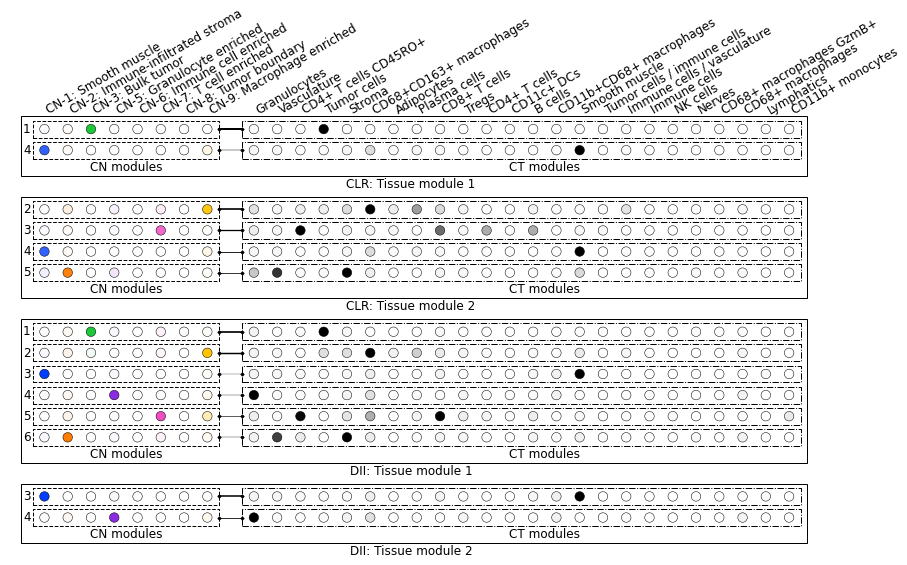

In [55]:
tensor_plots([dat_CLR, dat_DII], ind, ['CLR', 'DII'], scale=1, savename='../analysis_res/CRC/CNE/decomp.pdf')